# Air Quality Modeling - Exploration and Cleaning

## A. Introduction
Air quality describes the concentration of pollutants in the air and how they affect human health and the environment.
The Air Quality Index (AQI) is a standardized scale that converts pollutant concentrations into a single, interpretable number.

OpenAQ provides raw pollutant concentrations (and metadata like location and time) but not AQI because AQI depends on
regulatory standards, averaging windows, and unit conversions that vary by country and use case. We compute AQI ourselves.


## B. Data Loading
We load the local CSV and inspect schema and samples.

In [6]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)

ROOT = Path('..').resolve()
sys.path.append(str(ROOT / 'src'))

import importlib
import preprocessing
importlib.reload(preprocessing)

from preprocessing import load_raw_data


data_path = ROOT / 'data' / 'openaq.csv'
raw_df = load_raw_data(str(data_path))

print(raw_df.shape)
display(raw_df.head())
display(raw_df.dtypes)


(61177, 10)


,Country Code,city,location,coordinates,pollutant,source_name,unit,value,last_updated,Country Label
0,CN,NaN,市八十六中,"23.1047, 113.43319999999999",O3,ChinaAQIData,µg/m³,36.0,2021-08-09T12:00:00+01:00,China
1,CN,NaN,市农科院,"21.9508, 108.6553",SO2,ChinaAQIData,µg/m³,7.0,2020-12-31T17:00:00+01:00,China
2,CN,NaN,市发改委,"29.8454, 114.3107",PM2.5,ChinaAQIData,µg/m³,26.0,2021-08-09T12:00:00+01:00,China
3,CN,NaN,市委,"30.457600000000003, 106.63030000000002",O3,ChinaAQIData,µg/m³,91.0,2021-08-09T12:00:00+01:00,China
4,CN,NaN,市委党校,"27.731400000000004, 112.0194",NO2,ChinaAQIData,µg/m³,19.0,2021-08-09T12:00:00+01:00,China


Country Code      object
city              object
location          object
coordinates       object
pollutant         object
source_name       object
unit              object
value            float64
last_updated      object
Country Label     object
dtype: object

## C. Data Quality Checks
We check missing values, duplicates, unit inconsistencies, and outline an outlier detection plan.

,missing_pct
city,0.476421
Country Label,0.002076
coordinates,0.001144
location,0.000033
Country Code,0.000000
pollutant,0.000000
source_name,0.000000
unit,0.000000
value,0.000000
last_updated,0.000000


Duplicate rows: 0


,pollutant,unit,count
0,PM2.5,µg/m³,10656
1,PM10,µg/m³,9264
2,NO2,µg/m³,7487
3,O3,µg/m³,5820
4,SO2,µg/m³,5080
5,CO,µg/m³,3964
6,NO2,ppm,3636
7,O3,ppm,3557
8,SO2,ppm,2975
9,NO,ppm,2055


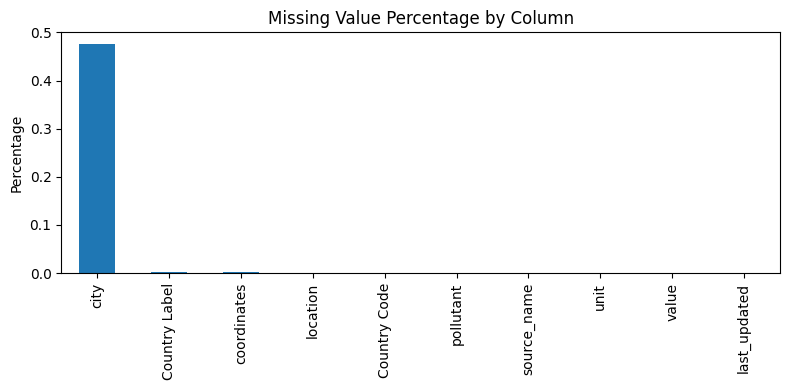

In [7]:
# Missing values
missing_pct = raw_df.isna().mean().sort_values(ascending=False)
display(missing_pct.to_frame('missing_pct'))

# Duplicates
dup_count = raw_df.duplicated().sum()
print(f'Duplicate rows: {dup_count}')

# Unit inconsistencies per pollutant
unit_counts = (raw_df[['pollutant', 'unit']].dropna().value_counts().reset_index())
unit_counts.columns = ['pollutant', 'unit', 'count']
display(unit_counts.head(20))

# Plot: missing value percentages
plt.figure(figsize=(8, 4))
missing_pct.plot(kind='bar')
plt.title('Missing Value Percentage by Column')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()


**Outlier detection plan**
- Use robust statistics (IQR/median absolute deviation) per pollutant.
- Compare extreme values to AQI breakpoints to flag implausible spikes.
- Review outliers per location to distinguish sensor faults vs real events.


(43787, 9)


,city,location,latitude,longitude,timestamp,pollutant,value_std,unit_std,source_name
0,NaN,市八十六中,23.1047,113.4332,2021-08-09 11:00:00,o3,0.018337,ppm,ChinaAQIData
1,NaN,市农科院,21.9508,108.6553,2020-12-31 16:00:00,so2,2.671297,ppb,ChinaAQIData
3,NaN,市委,30.4576,106.6303,2021-08-09 11:00:00,o3,0.046353,ppm,ChinaAQIData
4,NaN,市委党校,27.7314,112.0194,2021-08-09 11:00:00,no2,10.096718,ppb,ChinaAQIData
5,NaN,市审计局,25.8071,113.0383,2021-08-09 11:00:00,o3,0.057559,ppm,ChinaAQIData


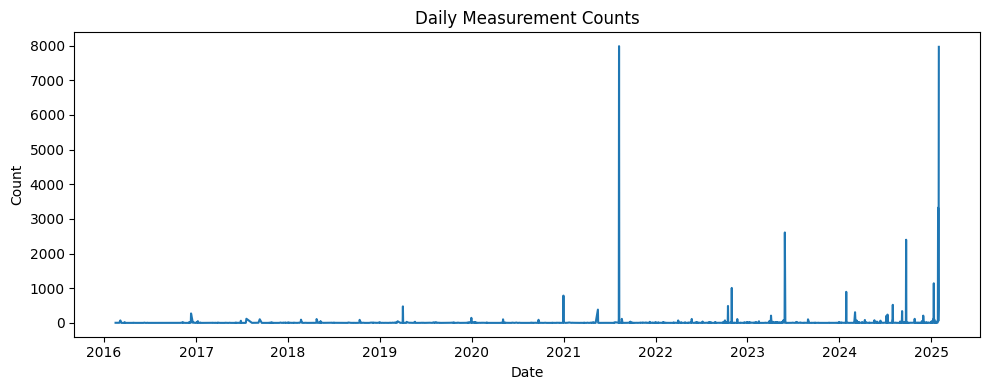

In [8]:
from preprocessing import clean_raw_data

clean_df = clean_raw_data(raw_df)
print(clean_df.shape)
display(clean_df.head())

# Save intermediate dataset
processed_long_path = ROOT / 'data' / 'processed_long.csv'
clean_df.to_csv(processed_long_path, index=False)

# Plot: measurement counts over time
counts = clean_df.groupby(clean_df['timestamp'].dt.date).size()
plt.figure(figsize=(10, 4))
counts.plot()
plt.title('Daily Measurement Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()
